In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [16]:
device = torch.device('mps')

In [17]:
train = pd.read_csv(r"input/train.csv",dtype=np.float32)
target_numpy = train.label.values
feature_numpy = train.loc[:, train.columns != 'label'].values/255

In [18]:
features_train, features_test, targets_train, targets_test = (
    train_test_split(feature_numpy,target_numpy,test_size = 0.2,random_state = 42)) 

In [19]:
featureTrain = torch.from_numpy(features_train)
targetTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

In [20]:
featureTest = torch.from_numpy(features_test)
targetTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [21]:
batch_size = 100
n_iters = 30000
n_epochs = int(n_iters * batch_size / len(features_train))

In [22]:
train = torch.utils.data.TensorDataset(featureTrain,targetTrain)
test = torch.utils.data.TensorDataset(featureTest,targetTest)


trainloader = torch.utils.data.DataLoader(train,batch_size=batch_size,shuffle=False)
testloader = torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=False)

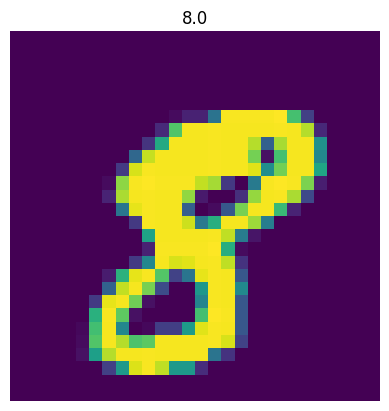

In [23]:
plt.imshow(feature_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(target_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [24]:
class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super(Net,self).__init__()
        hidden_dim = 150
# Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(in_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, out_dim)  
        
    def forward(self,x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out
    

In [25]:
# in_dim = 28*28
# out_dim = 10
# # model2 = Net(in_dim = 28*28,out_dim = 10)
# da = torch.from_numpy(feature_numpy[10].reshape(28,28))
# model2 = nn.Linear(28*28,10,dtype=torch.uint8)
# model2(da)
# # model2(torch.from_numpy(feature_numpy[10].reshape(28,28)))

In [34]:
in_dim = 28*28
out_dim = 10
model = Net(in_dim = in_dim,out_dim = out_dim)

# model.to(device)
loss_func = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

In [35]:
cnt = 0
loss_list = []
iter_list = []
for epoch in range(n_epochs):
    for i,(images,labels) in enumerate(trainloader):
        train = Variable(images.view(-1,28*28))
        train.to(device)
        
        
        # print(train.shape)
        
        out = model(train)
        labels = Variable(labels)
        optimizer.zero_grad()
        loss = loss_func(out,labels)
        loss.backward()
        optimizer.step()
        cnt += 1
        
        if cnt % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in testloader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iter_list.append(cnt)
        if cnt % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(cnt, loss.data, accuracy))

Iteration: 500  Loss: 1.748948574066162  Accuracy: 60.42856979370117%
Iteration: 1000  Loss: 0.8077144622802734  Accuracy: 80.13095092773438%
Iteration: 1500  Loss: 0.46868184208869934  Accuracy: 85.41666412353516%
Iteration: 2000  Loss: 0.4445408284664154  Accuracy: 87.83333587646484%
Iteration: 2500  Loss: 0.43426626920700073  Accuracy: 89.22618865966797%
Iteration: 3000  Loss: 0.18407046794891357  Accuracy: 89.89286041259766%
Iteration: 3500  Loss: 0.3370848596096039  Accuracy: 90.58333587646484%
Iteration: 4000  Loss: 0.1237400695681572  Accuracy: 91.13095092773438%
Iteration: 4500  Loss: 0.49118441343307495  Accuracy: 91.76190185546875%
Iteration: 5000  Loss: 0.17709402740001678  Accuracy: 91.8452377319336%
Iteration: 5500  Loss: 0.2609004080295563  Accuracy: 92.38095092773438%
Iteration: 6000  Loss: 0.34327176213264465  Accuracy: 92.82142639160156%
Iteration: 6500  Loss: 0.13796508312225342  Accuracy: 93.29762268066406%
Iteration: 7000  Loss: 0.2545457184314728  Accuracy: 93.5714

In [38]:
torch.save(model.state_dict(), '/Users/timli/Documents/DeepLearning/DeepLearningProjects/learn_torch/model_ann.pth')

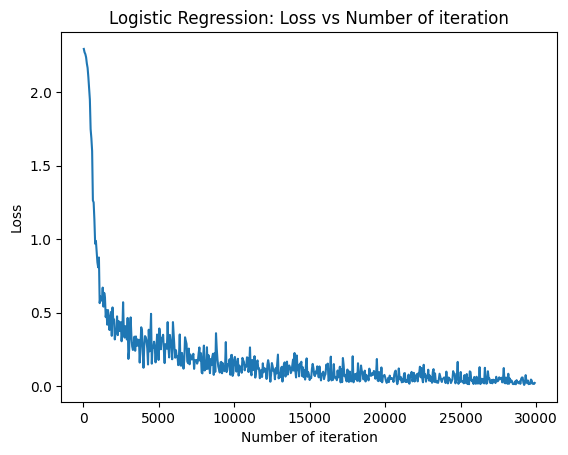

In [37]:
plt.plot(iter_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()
